<a href="https://colab.research.google.com/github/polo-music/test_tma/blob/main/test_tma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('classic')

url = 'https://raw.githubusercontent.com/polo-music/test_tma/main/CATB%20-%20CATB.csv'
df = pd.read_csv(url)
#cargamos el data frame
df = df.set_index(pd.DatetimeIndex(df['Date'].values))
df_2 = df.head(400)
#utilitzarem el dataframe 2 per test amb les primeres x dades
#l'index és la data
df_2 = df_2.set_index(pd.DatetimeIndex(df_2['Date'].values))
#quitar $ de las columnas
#definir el rango de valores y quitar $ de la primera posición
for i in range(0, len(df_2)):
  v = df_2.iat[i, 1]
  #definimos variable para quitar el $
  #print(v.strip('$'))
  v = v.strip('$')
  #añadimos la nueva columna con los datos sin $ en el dataframe
  df_2.iat[i, 1] = pd.to_numeric(v)

#ahora tenemos el dataset 2 con la columna close/last sin el $
print(df_2)

                  Date Close/Last  Volume   Open     High    Low
2016-02-01  02/01/2016         63    3708    $65    $68.6  $60.3
2016-02-02  02/02/2016       60.3    3276  $60.3    $63.3  $53.8
2016-02-03  02/03/2016       60.6    5761  $59.3    $63.1  $57.2
2016-02-04  02/04/2016       62.5    1975  $60.5  $62.986  $58.4
2016-02-05  02/05/2016       57.5    3075  $61.5    $62.1  $54.9
...                ...        ...     ...    ...      ...    ...
2017-08-24  08/24/2017       12.3    7238  $12.1    $12.4    $12
2017-08-25  08/25/2017       13.7   75001  $12.5    $13.7  $12.4
2017-08-28  08/28/2017       13.1   26972  $13.5    $13.8  $13.1
2017-08-29  08/29/2017       13.8   27346  $13.1      $14  $13.1
2017-08-30  08/30/2017       13.6   11934  $13.6  $13.899  $13.1

[400 rows x 6 columns]


In [86]:
#test algoritmo three moving avarage
#short fast moving avarage

#ahora podemos definir los indices ya que la funcion ewm exponential weight mean solo trabaja con int
shortEMA = df_2['Close/Last'].ewm(span=12, adjust = False).mean()
#definimos la funcion ewm a medio y largo plazo
middleEMA = df_2['Close/Last'].ewm(span=26, adjust = False).mean()
largeEMA = df_2['Close/Last'].ewm(span=100, adjust = False).mean()

#agragamos al datafram tres columnas con los exponential moving averages
df_2['Short EMA'] = shortEMA
df_2['Middle EMA'] = middleEMA
df_2['Large EMA'] = largeEMA

df_2

,Date,Close/Last,Volume,Open,High,Low,Short EMA,Middle EMA,Large EMA
2016-02-01,02/01/2016,63,3708,$65,$68.6,$60.3,63.000000,63.000000,63.000000
2016-02-02,02/02/2016,60.3,3276,$60.3,$63.3,$53.8,62.584615,62.800000,62.946535
2016-02-03,02/03/2016,60.6,5761,$59.3,$63.1,$57.2,62.279290,62.637037,62.900069
2016-02-04,02/04/2016,62.5,1975,$60.5,$62.986,$58.4,62.313245,62.626886,62.892146
2016-02-05,02/05/2016,57.5,3075,$61.5,$62.1,$54.9,61.572746,62.247117,62.785371
...,...,...,...,...,...,...,...,...,...
2017-08-24,08/24/2017,12.3,7238,$12.1,$12.4,$12,12.224970,12.369841,14.662829
2017-08-25,08/25/2017,13.7,75001,$12.5,$13.7,$12.4,12.451898,12.468371,14.643764
2017-08-28,08/28/2017,13.1,26972,$13.5,$13.8,$13.1,12.551606,12.515159,14.613194
2017-08-29,08/29/2017,13.8,27346,$13.1,$14,$13.1,12.743666,12.610332,14.597091


In [87]:
#definimos la funcion para comprar y vender acciones, que usa una sola variable de datos

def compra_venta(data, inv):
  
  vender = []
  comprar = []
  #listas para decidir si comprar o vender, si existe la lista con una señal de vender y
  #le llega otra de vender, debera vender primero la que ya tiene

  #avisos para señal de movimiento (de comprar o vender) para saber en que punto de la operación estamos
  #si tenemos señal de compra primero vender antes de comprar y si llegamos a la señal de venta sabemos que
  #hay que comprar antes de vender
  slarga = False
  scorta = False

  #loop sobre todo el dataframe
  for i in range(0, len(data)):
    #estrategia 1: si la media exponencial middle de un punto (dia) i del dataframe es inferior a la media exponencial
    #larga del mismo dia i y la media corta es inferior a la media middle se vende, y si las dos señales son false
    if data['Short EMA'][i] < data['Large EMA'][i] and data['Short EMA'][i] < data['Middle EMA'][i] and scorta == False:
      #si se cumplen todas estas condiciones comprar (añadir a la lista de compras el dia que deberiamos haber comprado)
      comprar.append(data['Close/Last'][i])
      #no añadir nada a la lista de vender pero mantener las posiciones de las dos listas parejas
      vender.append(np.nan)
      scorta = True #para saber que hemos comprado accion
      inv = inv - data['Close/Last'][i]

    #para vender las acciones que hemos comprado tenemos que haberlas comprado primero (scorta = true) y que la exponencial corta
    #cruze la exponencial media por arriba
    elif scorta == True and data['Short EMA'][i] > data['Middle EMA'][i] and data['Short EMA'][i] > data['Large EMA'][i]:
      comprar.append(np.nan)
      vender.append(data['Close/Last'][i])
      scorta = False
      inv = inv + data['Close/Last'][i]

    #lo mismo para la compra en largo
    elif data['Short EMA'][i] < data['Large EMA'][i] and data['Short EMA'][i] < data['Middle EMA'][i] and slarga == False:
      comprar.append(data['Close/Last'][i])
      vender.append(np.nan)
      slarga = True
      inv = inv - data['Close/Last'][i]
    
    elif slarga == True and data['Short EMA'][i] > data['Middle EMA'][i]:
      comprar.append(np.nan)
      vender.append(data['Close/Last'][i])
      slarga = False
      inv = inv + data['Close/Last'][i]
    #si no se cumple ninguna de las dos opciones de compra venta simplemente que no haga nada
    else:
      comprar.append(np.nan)
      vender.append(np.nan)

  return (comprar, vender, inv)



In [88]:
#agregar al datafreme las columnas de comprar y vender
inp = 1000
df_2['Comprar'] = compra_venta(df_2, inp)[0]
df_2['Vender'] = compra_venta(df_2, inp)[1]
df_2['$'] = compra_venta(df_2, inp)[2]

df_2

,Date,Close/Last,Volume,Open,High,Low,Short EMA,Middle EMA,Large EMA,Comprar,Vender,$
2016-02-01,02/01/2016,63,3708,$65,$68.6,$60.3,63.000000,63.000000,63.000000,NaN,NaN,1131.6
2016-02-02,02/02/2016,60.3,3276,$60.3,$63.3,$53.8,62.584615,62.800000,62.946535,60.3,NaN,1131.6
2016-02-03,02/03/2016,60.6,5761,$59.3,$63.1,$57.2,62.279290,62.637037,62.900069,60.6,NaN,1131.6
2016-02-04,02/04/2016,62.5,1975,$60.5,$62.986,$58.4,62.313245,62.626886,62.892146,NaN,NaN,1131.6
2016-02-05,02/05/2016,57.5,3075,$61.5,$62.1,$54.9,61.572746,62.247117,62.785371,NaN,NaN,1131.6
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-24,08/24/2017,12.3,7238,$12.1,$12.4,$12,12.224970,12.369841,14.662829,NaN,NaN,1131.6
2017-08-25,08/25/2017,13.7,75001,$12.5,$13.7,$12.4,12.451898,12.468371,14.643764,NaN,NaN,1131.6
2017-08-28,08/28/2017,13.1,26972,$13.5,$13.8,$13.1,12.551606,12.515159,14.613194,NaN,13.1,1131.6
2017-08-29,08/29/2017,13.8,27346,$13.1,$14,$13.1,12.743666,12.610332,14.597091,NaN,NaN,1131.6


Profit del 13.159999999999972%
Total: 1131.5999999999997


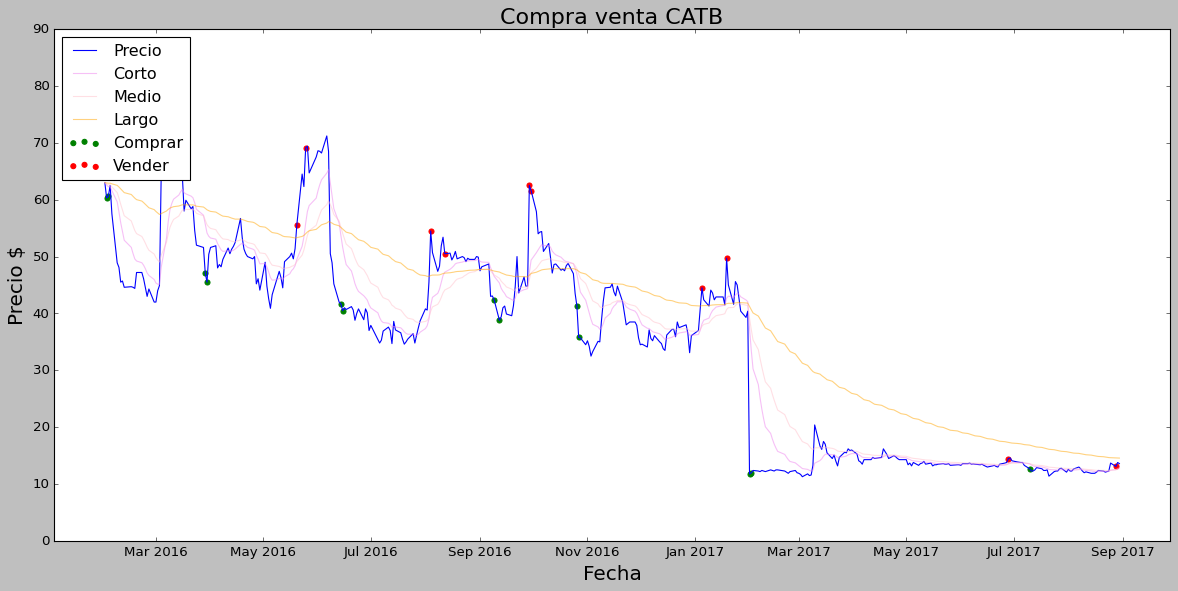

In [89]:
plt.figure(figsize=(18, 8))
plt.title('Compra venta CATB', fontsize = 20)
plt.plot(df_2['Close/Last'], label='Precio', color = 'blue')
plt.plot(shortEMA, label='Corto', color = 'violet', alpha = 0.5)
plt.plot(middleEMA, label = 'Medio', color = 'pink', alpha = 0.5)
plt.plot(largeEMA, label='Largo', color = 'orange', alpha = 0.5)

plt.xlabel('Fecha', fontsize = 18)
plt.ylabel('Precio $', fontsize = 18)
plt.yscale('linear')

plt.scatter(df_2.index, df_2['Comprar'], color = 'green', marker = 'o', label = 'Comprar')
plt.scatter(df_2.index, df_2['Vender'], color = 'red', marker = 'o', label = 'Vender')

plt.legend(loc = 'upper left')

print('Profit del ' + str(((df_2['$'][0]/inv)-1)*100) +'%')
print('Total: ' + str(df_2['$'][0]))
plt.show()